# Esercizio 2.2: Topic modelling

Il seguente esercizio consisterà nell'estrarre 3 topic da una lista di 30 documenti estratti da Wikipedia usando Sketch Engine

In particolare avremo i seguenti topic che cercheremo di estrarre:
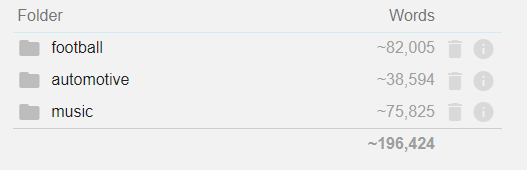

Dove per ogni topic abbiamo usato le seguenti pagine di Wikipedia:
<table><tr>
<td> 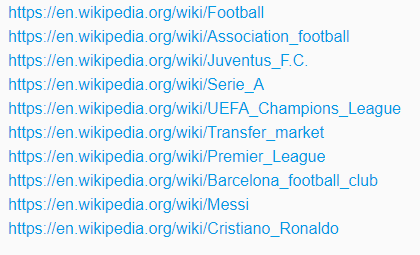 </td>
<td> 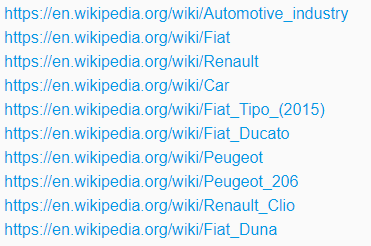 </td>
<td> 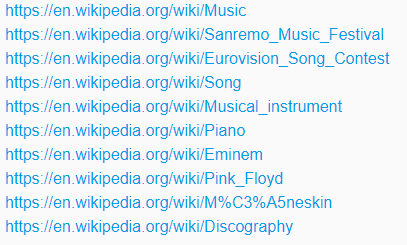 </td>
</tr></table>

Come si può notare dalla prima immagine c'è una differenza importante nel numero di parole tra i diversi topic quindi ci si aspetta che quello legato alle autovetture risulti più difficilmente individuabile dal programma

In [1]:
from nltk.corpus import stopwords
import os
import re
from pprint import pprint
# Carichiamo le stop words
stop_words = set(stopwords.words('english'))

def load_dataset(file):
    str = open(os.getcwd()+f'\\{file}.txt', 'r', encoding="utf8").read()
    list_document = []
    #extract all document
    docs = re.findall(r'<doc[^>]*(.*?)<\/doc>', str, re.DOTALL)
    #extract all sentence for document
    for doc in docs:
        list_document.append(''.join(re.findall(r'<p>(.*)</p>', doc)))
    return list_document

# list of document, each document is a string
corpus = load_dataset('corpus_2_2_big')

In [4]:
from gensim.models import CoherenceModel
import gensim

def make_bigrams(text):
    bigram = gensim.models.Phrases(corpus_sent, min_count=5)
    for idx in range(len(text)):
        for token in bigram[text[idx]]:
            if '_' in token:
                text[idx].append(token)
    return text

## Preprocessing

Come preprocessing si inizia con una regural expression per eliminare le nuove linee.

Segue una fase in cui filtriamo le stopwords, importate da nltk, e i simboli di punteggiatura.

In fine si è deciso di utilizzare la libreria di Spacy per effettuare un filtraggio sulle non-content words e allo stesso tempo 
estarne soltanto i Lemmi.

In [5]:
import spacy
from pprint import pprint
from gensim.utils import simple_preprocess

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# simple_preprocess splitta in parole e deacc rimuove accenti
def remove_stopwords_and_punct(texts):
    return [[word for word in simple_preprocess(str(doc),  deacc=True) if word not in stop_words] for doc in texts]

# load spacy corpus without parser and ner
nlp = spacy.load('en_core_web_lg', disable=['ner'])

# removing new line
corpus_sent = [re.sub(r'\s+', ' ', sent) for sent in corpus]

# remove punctuations and stop words
corpus_sent = remove_stopwords_and_punct(corpus_sent)

corpus_sent = make_bigrams(corpus_sent)

# lemmatization
corpus_sent = lemmatization(corpus_sent)

## LDA

A questo punto possiamo iniziare ad applicare la libreria `gensim` per l'estrazione dei topic.

Iniziamo definendo il Dictionary passando il nostro testo processato, costruiamo la lista delle frequenze e passiamo il tutto in pasto all'algoritmo LDA 
con la chiamata ```LdaModel(dictionary, term frequency, numero topic)```

In [6]:
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from pprint import pprint

# Creation Dictionary / elenco parole
common_dictionary  = corpora.Dictionary(corpus_sent)  
#common_dictionary.filter_extremes(no_below=10, no_above=0.5)

# Term Document Frequency 
common_corpus  = [common_dictionary.doc2bow(text) for text in corpus_sent]  

# Train the model on the corpus.
lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=3)

pprint(lda.print_topics())

[(0,
  '0.010*"car" + 0.009*"first" + 0.008*"player" + 0.008*"music" + '
  '0.008*"football" + 0.007*"time" + 0.007*"team" + 0.007*"goal" + '
  '0.007*"play" + 0.007*"year"'),
 (1,
  '0.011*"club" + 0.009*"football" + 0.009*"first" + 0.008*"player" + '
  '0.008*"team" + 0.007*"goal" + 0.007*"season" + 0.007*"year" + 0.006*"play" '
  '+ 0.006*"win"'),
 (2,
  '0.012*"music" + 0.010*"goal" + 0.008*"first" + 0.007*"club" + 0.006*"year" '
  '+ 0.006*"season" + 0.006*"also" + 0.006*"country" + 0.006*"player" + '
  '0.005*"score"')]


In [7]:
#!{sys.executable} -m pip install pyLDAvis
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda, common_corpus, common_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008062 -0.001968       1        1  39.645422
1     -0.006275 -0.004318       2        1  37.885283
0     -0.001786  0.006287       3        1  22.469295, topic_info=          Term        Freq       Total Category  logprob  loglift
3542       car  375.000000  375.000000  Default  30.0000  30.0000
373   football  464.000000  464.000000  Default  29.0000  29.0000
706     player  494.000000  494.000000  Default  28.0000  28.0000
3795     music  584.000000  584.000000  Default  27.0000  27.0000
946       team  406.000000  406.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
576      match   60.896612  309.747447   Topic3  -5.5139  -0.1336
1003       use   56.698459  291.090225   Topic3  -5.5854  -0.1429
1550       new   49.653174  233.378885   Topic3  -5.7181  -0.0546
768     record   50.259086  242.580705   Topic3  -5.7059  -0.0811
358      final   51.599629  301.617091   Topic3  -5.6796  -0.2726

[269 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1915      1  0.585166    aim
1915      2  0.243819    aim
1915      3  0.195055    aim
33        1  0.474760   also
33        2  0.332041   also
...     ...       ...    ...
1047      2  0.383558  world
1047      3  0.208701  world
1054      1  0.387956   year
1054      2  0.385714   year
1054      3  0.228737   year

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])